In [4]:
# ! wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

In [3]:
# ! unzip 10_food_classes_all_data.zip

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")  
%matplotlib inline

In [6]:
TRAIN_PATH = "10_food_classes_all_data/train"
TEST_PATH = "10_food_classes_all_data/test"

In [7]:
class_names = []
for i in os.listdir(TRAIN_PATH):
  class_names.append(i)

In [8]:
class_names

['ramen',
 'grilled_salmon',
 'chicken_curry',
 'ice_cream',
 'hamburger',
 'sushi',
 'steak',
 'pizza',
 'chicken_wings',
 'fried_rice']

In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [10]:
train_data = train_datagen.flow_from_directory(directory=TRAIN_PATH,
                                               target_size=(224,224),
                                               class_mode="categorical",  
                                               shuffle=True,
                                               seed=42)
test_data = test_datagen.flow_from_directory(directory=TEST_PATH,
                                             target_size=(224,224),
                                             class_mode="categorical",
                                             shuffle=True,
                                             seed=42)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [11]:
tf.random.set_seed(42)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(224,224,3)))
model.add(tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.AvgPool2D(pool_size=2))
model.add(tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.AvgPool2D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [12]:
model.fit(train_data, epochs=5, validation_data=test_data)

Epoch 1/5
235/235 [==============================] - 60s 210ms/step - loss: 2.1058 - accuracy: 0.2403 - val_loss: 1.9716 - val_accuracy: 0.2852
Epoch 2/5
235/235 [==============================] - 48s 205ms/step - loss: 1.8643 - accuracy: 0.3585 - val_loss: 1.8967 - val_accuracy: 0.3568
Epoch 3/5
235/235 [==============================] - 49s 207ms/step - loss: 1.6231 - accuracy: 0.4544 - val_loss: 1.8528 - val_accuracy: 0.3464
Epoch 4/5
235/235 [==============================] - 49s 207ms/step - loss: 1.2821 - accuracy: 0.5816 - val_loss: 2.0301 - val_accuracy: 0.3256
Epoch 5/5
235/235 [==============================] - 48s 205ms/step - loss: 0.8669 - accuracy: 0.7271 - val_loss: 2.2876 - val_accuracy: 0.3212


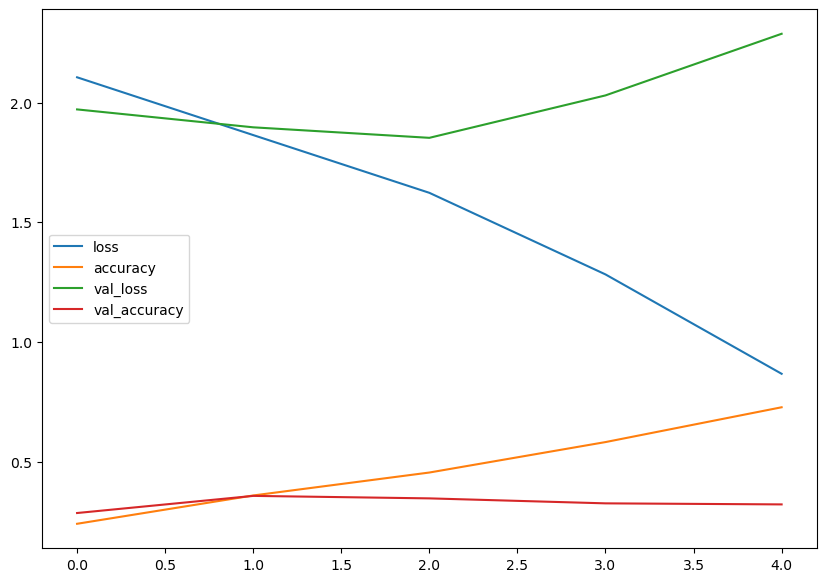

In [13]:
pd.DataFrame(model.history.history).plot(figsize=(10,7))
plt.show()

In [14]:
train_augmented_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                       rotation_range=0.2,
                                                                       shear_range=0.2,
                                                                       zoom_range=0.2,
                                                                       width_shift_range=0.2,
                                                                       height_shift_range=0.2,
                                                                       horizontal_flip=True)

In [15]:
train_data_augmented = train_augmented_datagen.flow_from_directory(directory=TRAIN_PATH,
                                                                   target_size=(224,224),
                                                                   class_mode="categorical",
                                                                   seed=42,
                                                                   shuffle=True)

Found 7500 images belonging to 10 classes.


In [16]:
history = model.fit(train_data_augmented, epochs=10, validation_data=test_data)

Epoch 1/10
235/235 [==============================] - 124s 527ms/step - loss: 2.1032 - accuracy: 0.2735 - val_loss: 1.8728 - val_accuracy: 0.3584
Epoch 2/10
235/235 [==============================] - 123s 522ms/step - loss: 1.9725 - accuracy: 0.3207 - val_loss: 1.8208 - val_accuracy: 0.3808
Epoch 3/10
235/235 [==============================] - 125s 530ms/step - loss: 1.9405 - accuracy: 0.3275 - val_loss: 1.8477 - val_accuracy: 0.3624
Epoch 4/10
235/235 [==============================] - 124s 527ms/step - loss: 1.9231 - accuracy: 0.3352 - val_loss: 1.7888 - val_accuracy: 0.3820
Epoch 5/10
235/235 [==============================] - 124s 529ms/step - loss: 1.9047 - accuracy: 0.3472 - val_loss: 1.7395 - val_accuracy: 0.4008
Epoch 6/10
235/235 [==============================] - 123s 523ms/step - loss: 1.8777 - accuracy: 0.3564 - val_loss: 1.7148 - val_accuracy: 0.4244
Epoch 7/10
235/235 [==============================] - 124s 526ms/step - loss: 1.8632 - accuracy: 0.3643 - val_loss: 1.7153 -

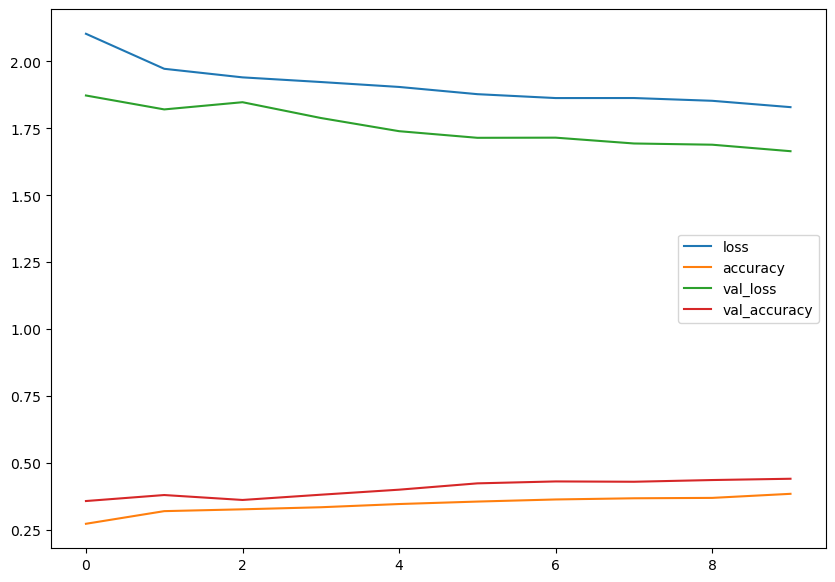

In [18]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.show()

In [19]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [20]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if (len(pred[0] > 1)):
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [21]:
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


1/1 [==============================] - 0s 185ms/step


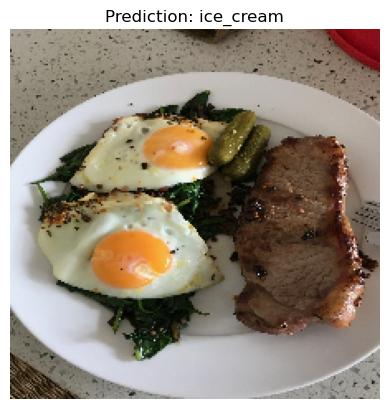

In [22]:
pred_and_plot(model=model, 
              filename="03-steak.jpeg", 
              class_names=class_names)

1/1 [==============================] - 0s 20ms/step


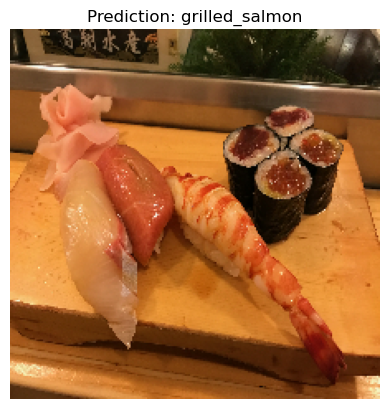

In [23]:
pred_and_plot(model, 
              "03-sushi.jpeg", 
              class_names)

1/1 [==============================] - 0s 18ms/step


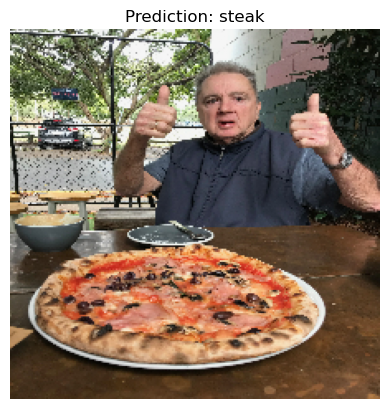

In [24]:
pred_and_plot(model, 
              "03-pizza-dad.jpeg", 
              class_names)